In [1]:
from pathlib import Path
from functools import partial

import pandas as pd
from scipy.stats import variation

#### Read the subset of profiles with overlapping ORFs (from Step #3)

In [2]:
ann_df = pd.read_parquet("output/subset_profiles.parquet")

#### Plot cell counts for the subset

mean: 1038.957, median: 1074.000, mode: 1091.000, std: 200.529, min: 137.000, max: 1648.000
Replicate counts:
 5     3577
10      37
4        2
Name: Metadata_Vector, dtype: int64


<Axes: ylabel='Frequency'>

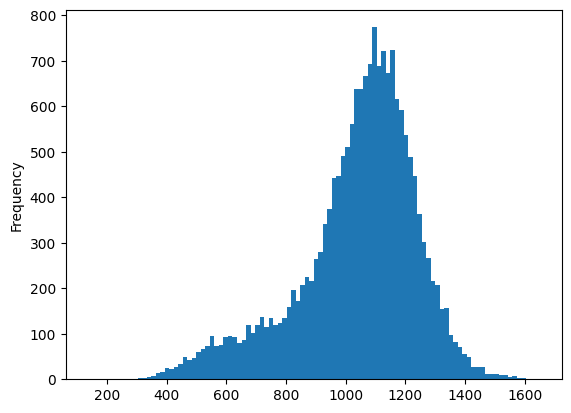

In [3]:
def print_moments(s):
    print(
        f"mean: {s.mean():.3f}, median: {s.median():.3f}, mode: {s.mode().to_list()[-1]:.3f}, "
        f"std: {s.std():.3f}, min: {s.min():.3f}, max: {s.max():.3f}"
    )


ann_df_trt = ann_df[ann_df.Metadata_pert_type == "trt"]
print_moments(ann_df_trt.Cells_Count)
print(
    "Replicate counts:\n",
    ann_df_trt.groupby("Metadata_JCP2022")["Metadata_Vector"].count().value_counts(),
)
ann_df_trt.Cells_Count.plot(kind="hist", bins=100)

#### Assess cell count variability per ORF by calculating the coefficient of variation

Considerations for using CoV:
- most (99%) of ORFs have exactly 5 replicates
- since the distribution is skewed, one should use DDoF=1

mean: 0.107, median: 0.081, mode: 0.524, std: 0.076, min: 0.009, max: 0.524


<Axes: ylabel='Frequency'>

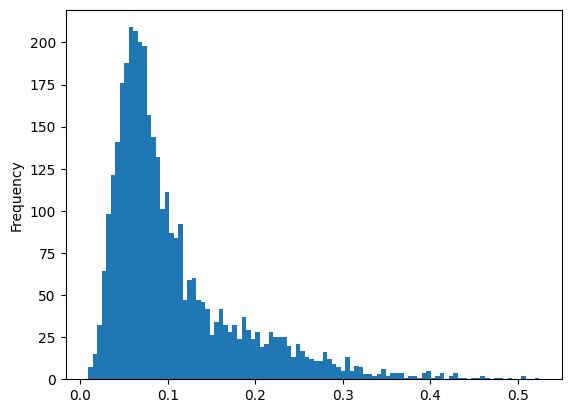

In [4]:
variation_ddof1 = partial(variation, ddof=1)
cell_count_cvar = ann_df_trt.groupby("Metadata_JCP2022")["Cells_Count"].agg(
    variation_ddof1
)

print_moments(cell_count_cvar)
cell_count_cvar.plot(kind="hist", bins=100)

#### Separate ORFs with high and low cell count variability by an arbitrary threshold

2588


<Axes: ylabel='Frequency'>

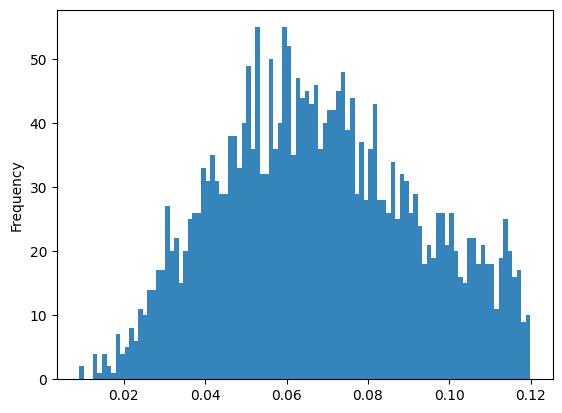

In [5]:
cutoff = 0.12

print((cell_count_cvar < cutoff).sum())
cell_count_cvar[cell_count_cvar < cutoff].plot(kind="hist", bins=100, alpha=0.9)

1028


<Axes: ylabel='Frequency'>

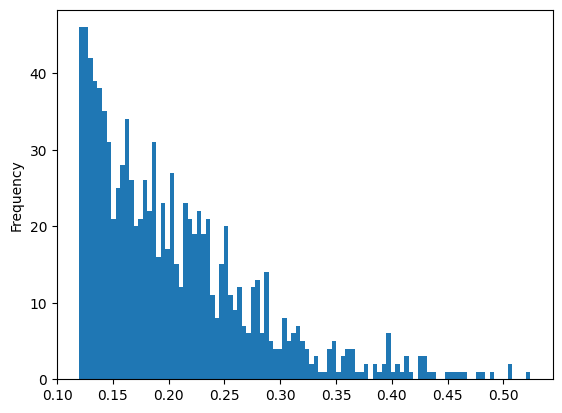

In [6]:
print((cell_count_cvar > cutoff).sum())
cell_count_cvar[cell_count_cvar > cutoff].plot(kind="hist", bins=100)

Low cell count variability (orange):
mean: 1097.740, median: 1107.000, mode: 1125.000, std: 146.641, min: 400.000, max: 1604.000
High cell count variability (blue):
mean: 893.835, median: 908.000, mode: 982.000, std: 238.358, min: 137.000, max: 1648.000


<Axes: ylabel='Frequency'>

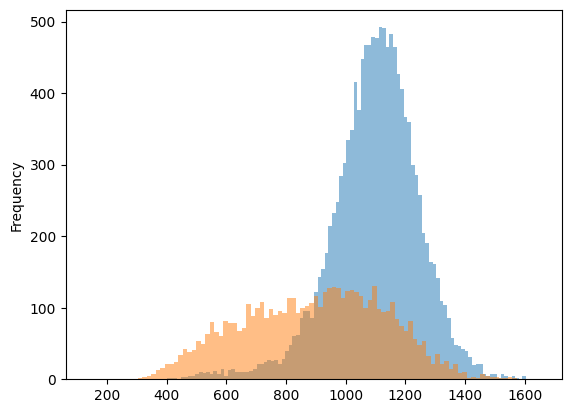

In [7]:
low_cvar_idx = cell_count_cvar[cell_count_cvar < cutoff].index
ann_df_trt_low_cvar = ann_df_trt.loc[ann_df_trt["Metadata_JCP2022"].isin(low_cvar_idx)]
ann_df_trt_high_cvar = ann_df_trt.loc[
    ~ann_df_trt["Metadata_JCP2022"].isin(low_cvar_idx)
]

print("Low cell count variability (orange):")
print_moments(ann_df_trt_low_cvar.Cells_Count)
ann_df_trt_low_cvar.Cells_Count.plot(kind="hist", bins=100, alpha=0.5)

print("High cell count variability (blue):")
print_moments(ann_df_trt_high_cvar.Cells_Count)
ann_df_trt_high_cvar.Cells_Count.plot(kind="hist", bins=100, alpha=0.5)

##### replicate counts are presered

In [8]:
print(
    "Replicate counts:\n",
    ann_df_trt.groupby("Metadata_JCP2022")["Metadata_Vector"].count().value_counts(),
)

Replicate counts:
 5     3577
10      37
4        2
Name: Metadata_Vector, dtype: int64


#### Save low cell count variability ORF metadata

In [9]:
cell_count_cvar.name = "Metadata_Cell_Count_CoV"
cell_count_cvar.to_csv("output/cell_count_per_orf.csv")

In [10]:
ann_df_trt_low_cvar.to_parquet(
    "output/subset_profiles_low_cvar_metadata.parquet", index=False
)